In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5452 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 5452 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5452 tips and 5450 internal nodes ]


In [5]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq = transform_sample_counts(physeq, function(x) x / sum(x))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
             diff          lwr         upr     p adj
1-0  3.387305e-03 -0.013071744 0.019846354 0.9903917
2-0  1.039255e-02 -0.006066503 0.026851595 0.4397017
3-0  8.404920e-03 -0.008054129 0.024863969 0.6661995
5-0  3.326895e-03 -0.013132154 0.019785944 0.9911528
7-0  3.932278e-03 -0.012526772 0.020391327 0.9811650
2-1  7.005241e-03 -0.009453808 0.023464291 0.8108509
3-1  5.017615e-03 -0.011441434 0.021476664 0.9464493
5-1 -6.041008e-05 -0.016519459 0.016398639 1.0000000
7-1  5.449728e-04 -0.015914077 0.017004022 0.9999987
3-2 -1.987626e-03 -0.018446675 0.014471423 0.9992313
5-2 -7.065651e-03 -0.023524701 0.009393398 0.8052855
7-2 -6.460268e-03 -0.022919318 0.009998781 0.8574948
5-3 -5.078025e-03 -0.021537075 0.011381024 0.9437545
7-3 -4.472642e-03 -0.020931692 0.011986407 0.9669624
7-5  6.053829e-04 -0.015853666 0.017064432 0.9999978



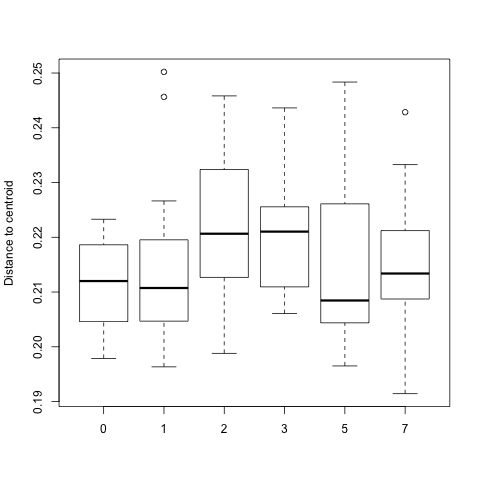

In [7]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "unifrac")
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Day)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here. Some worry re. Kaolinite, as expected, and soils look tight too.

In [10]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "unifrac", weighted=TRUE)

d.adonis = adonis(d ~ sample_data(physeq)$Day + sample_data(physeq)$Trtmt + sample_data(physeq)$Cosm, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(physeq)$Day + sample_data(physeq)$Trtmt +      sample_data(physeq)$Cosm, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
sample_data(physeq)$Day    5  0.005824 0.0011649  2.4661 0.08392  0.005 ** 
sample_data(physeq)$Trtmt  1  0.001408 0.0014079  2.9807 0.02029  0.041 *  
sample_data(physeq)$Cosm  10  0.036194 0.0036194  7.6627 0.52149  0.001 ***
Residuals                 55  0.025979 0.0004723         0.37431           
Total                     71  0.069405                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is not a significant effect of day or treatment, across samples, nor is there an interaction.  
BUT when we take into account microcosm, all effects are significant:  
Trtmt p=0.04, Day p = 0.005, Cosm p = 0.001